## 목차
1. 데이터 준비  
    [1-1. 라이브러리 불러오기](#라이브러리-불러오기)  
    [1-2. 데이터 불러오기](#데이터-불러오기--전처리)  
2. 가설 검증
    [2-1. 노쇼 수 가설 검증](#가설--특정-시간대요일에-노쇼-물품이-많을-것이다)
    [2-2. 마감 임박도와 거래 성사율 가설 검증](#가설-4-마감-기한이-임박한-상품일-수록-거래-성사율이-높아질-것이다)
3. GPT
    [3-1. GPT description 최소 글자수](#description-최소-글자수-판단하기)

# 라이브러리 불러오기

In [34]:
import pickle
import pandas as pd
import os
import openai
import json
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
import statsmodels
from scipy import stats

# 데이터 불러오기 & 전처리

In [26]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'preprocessing')
data_file_path = os.path.join(data_directory, 'processed_data.pkl')
df = pd.read_pickle(data_file_path)

In [27]:
df.post_time.unique()

array([datetime.datetime(2024, 10, 11, 19, 12, 1, 203000),
       datetime.datetime(2024, 10, 11, 19, 1, 1, 203000),
       datetime.datetime(2024, 10, 11, 18, 58, 1, 203000), ...,
       '2024-07-24 10:47:40', '2024-07-24 09:59:22',
       '2024-07-24 09:33:57'], dtype=object)

# 가설 : 특정 시간대/요일에 노쇼 물품이 많을 것이다.

C:\Users\sera\AppData\Local\Temp\ipykernel_16052\2691061071.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_post_df['post_time'] = pd.to_datetime(filter_post_df['post_time'], errors='coerce')  # 오류 발생 시 NaT로 설정
C:\Users\sera\AppData\Local\Temp\ipykernel_16052\2691061071.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_post_df['weekday'] = filter_post_df['post_time'].dt.day_name()  # 요일 이름
C:\Users\sera\AppData\Local\Temp\ipykernel_16052\2691061071.py:9: SettingWithCopyWarning: 
A value 

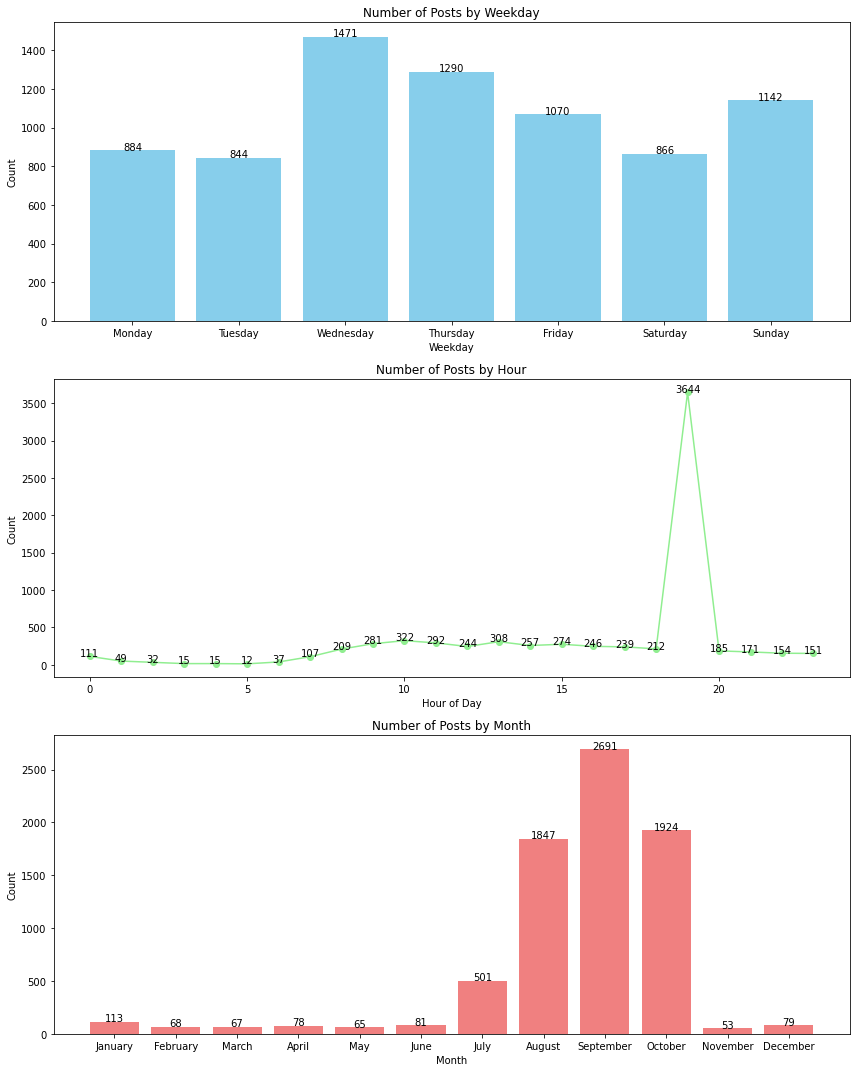

월별 카이제곱 통계량: 1058.488109034863, p-value: 4.937693326313525e-220
대립가설을 채택합니다: 특정 월에 노쇼 품목 수가 많다.


In [41]:
# 'post_time'에서 2개월 전, 3개월 전 값을 제외
filter_post_df = df[(df['post_time'] != '2개월 전') & (df['post_time'] != '3개월 전')]

# 'post_time'에서 요일과 시간, 월 추출
filter_post_df['post_time'] = pd.to_datetime(filter_post_df['post_time'], errors='coerce')  # 오류 발생 시 NaT로 설정
filter_post_df = filter_post_df.dropna(subset=['post_time'])  # 변환할 수 없는 값 제거

filter_post_df['weekday'] = filter_post_df['post_time'].dt.day_name()  # 요일 이름
filter_post_df['hour'] = filter_post_df['post_time'].dt.hour  # 시간 (0-23)
filter_post_df['month'] = filter_post_df['post_time'].dt.month_name()  # 월 이름

# 월 순서 설정 (1월부터 12월까지)
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 
                  'July', 'August', 'September', 'October', 'November', 'December']
filter_post_df['month'] = pd.Categorical(filter_post_df['month'], categories=ordered_months, ordered=True)

# 노쇼 여부 정의 (판매 중 -> True, 판매 완료 -> False)
filter_post_df['no_show'] = filter_post_df['status'] == '판매중'

# 월별 갯수 집계
month_counts = filter_post_df['month'].value_counts().sort_index()

# 그래프 설정
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# 요일별 갯수 시각화 (막대 그래프)
axs[0].bar(weekday_counts.index, weekday_counts.values, color='skyblue')
axs[0].set_title('Number of Posts by Weekday')
axs[0].set_xlabel('Weekday')
axs[0].set_ylabel('Count')

# 개수 표시
for i, count in enumerate(weekday_counts):
    axs[0].text(i, count + 2, str(count), ha='center', fontsize=10)

# 시간대별 갯수 시각화 (선 그래프)
axs[1].plot(hour_counts.index, hour_counts.values, marker='o', color='lightgreen')
axs[1].set_title('Number of Posts by Hour')
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Count')

# 개수 표시
for i, count in enumerate(hour_counts):
    axs[1].text(i, count + 2, str(count), ha='center', fontsize=10)

# 월별 갯수 시각화 (막대 그래프)
axs[2].bar(month_counts.index, month_counts.values, color='lightcoral')
axs[2].set_title('Number of Posts by Month')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Count')

# 개수 표시
for i, count in enumerate(month_counts):
    axs[2].text(i, count + 2, str(count), ha='center', fontsize=10)

# 레이아웃 조정 및 그래프 출력
plt.tight_layout()
plt.show()

# 월별 교차표 생성
month_cross_tab = pd.crosstab(filter_post_df['month'], filter_post_df['no_show'], margins=False)

# 카이제곱 검정 수행
chi2_stat_month, p_value_month, _, _ = stats.chi2_contingency(month_cross_tab)

# 결과 출력
print(f"월별 카이제곱 통계량: {chi2_stat_month}, p-value: {p_value_month}")

if p_value_month < 0.05:
    print("대립가설을 채택합니다: 특정 월에 노쇼 품목 수가 많다.")
else:
    print("대립가설을 기각합니다: 월별로 노쇼 품목 수에 유의미한 차이가 없다.")


In [35]:
# 교차표 생성
day_cross_tab = pd.crosstab(df['day_of_week'], df['no_show'], margins=False)

# 카이제곱 검정 수행
chi2_stat_day, p_value_day, _, _ = stats.chi2_contingency(day_cross_tab)

# 결과 출력
print(f"요일별 카이제곱 통계량: {chi2_stat_day}, p-value: {p_value_day}")

if p_value_day < 0.05:
    print("대립가설을 채택합니다: 특정 요일에 노쇼 품목 수가 많다.")
else:
    print("대립가설을 기각합니다: 요일별로 노쇼 품목 수에 유의미한 차이가 없다.")

# 교차표 생성
hour_cross_tab = pd.crosstab(df['hour'], df['no_show'], margins=False)

# 카이제곱 검정 수행
chi2_stat_hour, p_value_hour, _, _ = stats.chi2_contingency(hour_cross_tab)

# 결과 출력
print(f"시간대별 카이제곱 통계량: {chi2_stat_hour}, p-value: {p_value_hour}")

if p_value_hour < 0.05:
    print("대립가설을 채택합니다: 특정 시간대에 노쇼 품목 수가 많다.")
else:
    print("대립가설을 기각합니다: 시간대별로 노쇼 품목 수에 유의미한 차이가 없다.")


KeyError: 'day_of_week'

In [30]:
filter_post_df

,platform,original_link,post_time,title,view_count,like_count,price,images,description,category,...,options,check_in_out_time,shipping_fee,transaction_location,transaction_method,city,city_goo,city_dong,weekday,hour
0,당근마켓,https://www.daangn.com/articles/846645149,2024-10-11 19:12:01.203,호텔숙바퀀,25.0,0.0,10000.0,https://img.kr.gcp-karroter.net/origin/article...,6시입실 내일12시퇴실\n가려했는데같이가는사람이 시간이 안맞아서요~,티켓/교환권,...,NaN,NaN,NaN,NaN,NaN,None,계양구,작전서운동,Friday,19
1,당근마켓,https://www.daangn.com/articles/846644988,2024-10-11 19:12:01.203,용산역 호텔숙박권,15.0,1.0,280000.0,https://img.kr.gcp-karroter.net/origin/article...,용산역 4성급 호텔 이비스 스타일 앰버서더 숙박권입니다! \n날짜 내일 10월 *...,티켓/교환권,...,NaN,NaN,NaN,NaN,NaN,서울특별시,강남구,역삼동,Friday,19
2,당근마켓,https://www.daangn.com/articles/846639021,2024-10-11 19:01:01.203,호텔 아쿠아펠리스 숙박권,79.0,2.0,100000.0,https://img.kr.gcp-karroter.net/origin/article...,사정이생겨 못가게되서\n선착순한명 싸게드릴께요,티켓/교환권,...,NaN,NaN,NaN,NaN,NaN,None,수영구,망미동,Friday,19
3,당근마켓,https://www.daangn.com/articles/846637216,2024-10-11 18:58:01.203,워커힐호텔 피자힐,39.0,2.0,90000.0,https://img.kr.gcp-karroter.net/origin/article...,피자힐 10만원권 9만원에 판매합니다~!,티켓/교환권,...,NaN,NaN,NaN,NaN,NaN,서울특별시,관악구,신림동,Friday,18
4,당근마켓,https://www.daangn.com/articles/846637088,2024-10-11 18:58:01.203,대만 시먼딩 puri ximen 호텔 양도(3/1-3/3),6.0,1.0,150000.0,https://img.kr.gcp-karroter.net/origin/article...,대만 시먼딩에 위치한 puri ximen 호텔 양도합니다\n내년 연휴인 3/1-3/...,티켓/교환권,...,NaN,NaN,NaN,NaN,NaN,익산시,None,None,Friday,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,중고나라,https://web.joongna.com/product/177764839,2024-07-24 10:39:59.000,롯데호텔 시그니엘서울 애프터눈티 세트 16>13,20.0,0.0,130000.0,https://img2.joongna.com/cafe-article-data/liv...,16>13,기타 티켓/쿠폰/이용권,...,NaN,NaN,NaN,NaN,NaN,None,None,None,Wednesday,10
7827,중고나라,https://web.joongna.com/product/177767396,2024-07-24 10:55:25.000,영등포 리더스 호텔(모텔)7/27-28디락스 트윈룸 숙박권 양도합니다,28.0,0.0,70000.0,/cafe-article-data/live/2024/07/24/1067914533/...,일정에 갑자기 차질이 생겨서 숙박권 판매 하려고 합니다 혹시 생각 있으신 분은 연락...,여행숙박/이용권,...,NaN,NaN,NaN,NaN,NaN,None,None,None,Wednesday,10
7828,중고나라,https://web.joongna.com/product/177766185,2024-07-24 10:47:40.000,롯데호텔통합숙박권,93.0,2.0,300000.0,https://img2.joongna.com/cafe-article-data/liv...,롯데호텔통합숙박권입니다 사용처 및 구성은 사진에 나와있습니다 24년 12월 말까지 ...,여행숙박/이용권,...,NaN,NaN,NaN,NaN,NaN,None,None,None,Wednesday,10
7829,중고나라,https://web.joongna.com/product/177758738,2024-07-24 09:59:22.000,씨마크 호텔이용권 (11만원),22.0,1.0,85000.0,https://img2.joongna.com/cafe-article-data/liv...,호텔이용권입니다 11만원 이용권 24.8.31 까지,여행숙박/이용권,...,NaN,NaN,NaN,NaN,NaN,None,None,None,Wednesday,9


In [31]:
# 'post_time'의 빈도 수를 계산하고 정렬
post_time_counts = filter_post_df['post_time'].value_counts().sort_index()

# 정렬된 결과 출력
post_time_counts = pd.DataFrame(post_time_counts)
# 새로운 인덱스 추가 (기본적인 정수 인덱스)
post_time_counts.reset_index(drop=False, inplace=True)

# 결과 출력
post_time_counts

,index,post_time
0,2022-10-11 19:18:24.320,1
1,2023-10-11 19:18:24.312,3
2,2023-10-11 19:18:24.314,2
3,2023-10-11 19:18:24.320,10
4,2023-11-11 19:18:24.311,4
...,...,...
4784,2024-10-11 19:04:01.245,1
4785,2024-10-11 19:04:40.000,1
4786,2024-10-11 19:12:01.203,2
4787,2024-10-11 19:14:00.213,1


# 가설 4: 마감 기한이 임박한 상품일 수록 거래 성사율이 높아질 것이다.

In [ ]:
# expiration_endate를 날짜 형식으로 변환
df['expiration_endate'] = pd.to_datetime(df['expiration_endate'], format='%Y.%m.%d', errors='coerce')

# 현재 날짜 구하기 (Timestamp 형식으로 변환)
today = pd.Timestamp(datetime.date.today())

# 현재 날짜와 expiration_endate의 차이 계산 (날짜 단위)
df['days_until_expiration'] = (df['expiration_endate'] - today).dt.days

# 고유한 값 확인
df['days_until_expiration'].value_counts()

In [104]:
filter_df = df[df['days_until_expiration']>=0]
filter_df.status.value_counts()

판매중     263
판매완료      8
Name: status, dtype: int64

In [ ]:
# 거래 상태 '판매 완료'와 '판매중'을 구분하여 수치화
df['status'] = df['status'].map({'판매 완료': 1, '판매중': 0})  # 판매 완료를 1로, 판매중을 0으로 매핑

# 남은 일 수에 따라 그룹화하여 거래 성사율 계산
summary = df.groupby('days_until_expiration')['status'].agg(['mean', 'count']).reset_index()
summary.columns = ['days_until_expiration', 'completion_rate', 'total_sales']

# 거래 성사율을 비율로 표현
summary['completion_rate'] = summary['completion_rate'] * 100  # 비율로 변환 (0~100%)

print(summary)

In [ ]:
# 교차표 생성
cross_tab = pd.crosstab(df['days_until_expiration'], df['status'], margins=False)

# 카이제곱 검정 수행
chi2_stat, p_value, _, _ = stats.chi2_contingency(cross_tab)

# 결과 출력
print(f"카이제곱 통계량: {chi2_stat}, p-value: {p_value}")

if p_value < 0.05:
    print("대립가설을 채택합니다: 마감 기한이 임박한 상품일수록 거래 성사율이 높아진다.")
else:
    print("대립가설을 기각합니다: 마감 기한과 거래 성사율 사이에 유의미한 차이가 없습니다.")

In [ ]:
# 거래 성사율 시각화
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    x='days_until_expiration',
    y='completion_rate',
    data=summary,
    palette='viridis'  # 색상 팔레트 설정
)

# 그래프 제목 및 레이블 설정
plt.title('마감 기한에 따른 거래 성사율', fontsize=18)
plt.xlabel('남은 일 수', fontsize=14)
plt.ylabel('거래 성사율 (%)', fontsize=14)
plt.xticks(rotation=45)  # x축 레이블 회전
plt.yticks(fontsize=12)
plt.grid(axis='y')  # y축 그리드 표시

# 바 위에 값 표시
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.1f}%', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='baseline', fontsize=12, color='black', 
                      xytext=(0, 5), textcoords='offset points')

plt.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
# 거래 성사 여부 시각화 (스택형 바 차트)
plt.figure(figsize=(12, 6))
stacked_bar = cross_tab.plot(kind='bar', stacked=True, color=['#4CAF50', '#F44336'], figsize=(12, 6))

# 그래프 제목 및 레이블 설정
plt.title('마감 기한에 따른 거래 성사 여부', fontsize=18)
plt.xlabel('남은 일 수', fontsize=14)
plt.ylabel('거래 수', fontsize=14)
plt.xticks(rotation=45)  # x축 레이블 회전
plt.legend(['판매 완료', '판매중'], fontsize=12)

plt.tight_layout()  # 레이아웃 조정
plt.show()

# description 최소 글자수 판단하기

In [37]:
# description의 글자 수를 계산하는 열 추가
df['description_length'] = df['description'].apply(len)

# expiration_stdate 이후의 열 목록
generated_columns = df.columns[16:]  # expiration_stdate 이후의 필드들

# 각 행의 null 값 개수를 계산하여 null_count 열 추가
df['null_count'] = df[generated_columns].isnull().sum(axis=1)

In [40]:
# 상관계수 계산 
correlation = df['description_length'].corr(df['null_count'])
print(f"Description Length와 Null Count 간의 상관계수: {correlation}")

Description Length와 Null Count 간의 상관계수: -0.12301267366081256


In [41]:
# 설명 변수: Description Length
X = df['description_length']

# 종속 변수: Null Count
y = df['null_count']

# 상수 추가
X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.OLS(y, X)
result = model.fit()

# 결과 출력
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             null_count   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     29.36
Date:                   목, 10 10 2024   Prob (F-statistic):           6.76e-08
Time:                        23:02:47   Log-Likelihood:                -4364.9
No. Observations:                1913   AIC:                             8734.
Df Residuals:                    1911   BIC:                             8745.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.2522      0

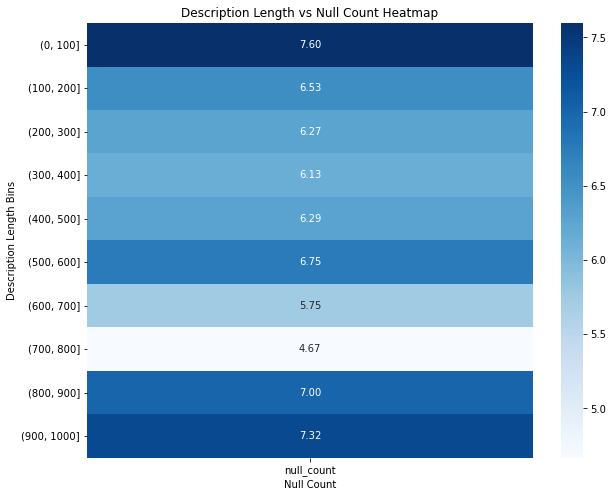

In [44]:
# Description Length를 범위로 나눔 (예: 10자 단위로 구분)
df['description_bin'] = pd.cut(df['description_length'], bins=range(0, df['description_length'].max() + 10, 100))

# description_bin별로 null_count 평균을 계산
heatmap_data = df.groupby('description_bin')['null_count'].mean().reset_index()

# 피벗 테이블 형태로 데이터 변환 (필요시 사용)
heatmap_data_pivot = heatmap_data.pivot_table(index='description_bin', values='null_count')

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_pivot, annot=True, cmap='Blues', fmt='.2f')

plt.title('Description Length vs Null Count Heatmap')
plt.ylabel('Description Length Bins')
plt.xlabel('Null Count')

plt.show()

C:\Users\sera\AppData\Local\Temp\ipykernel_324\3882653905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['description_bin'] = pd.cut(df_filtered['description_length'], bins=range(0, 210, 10))


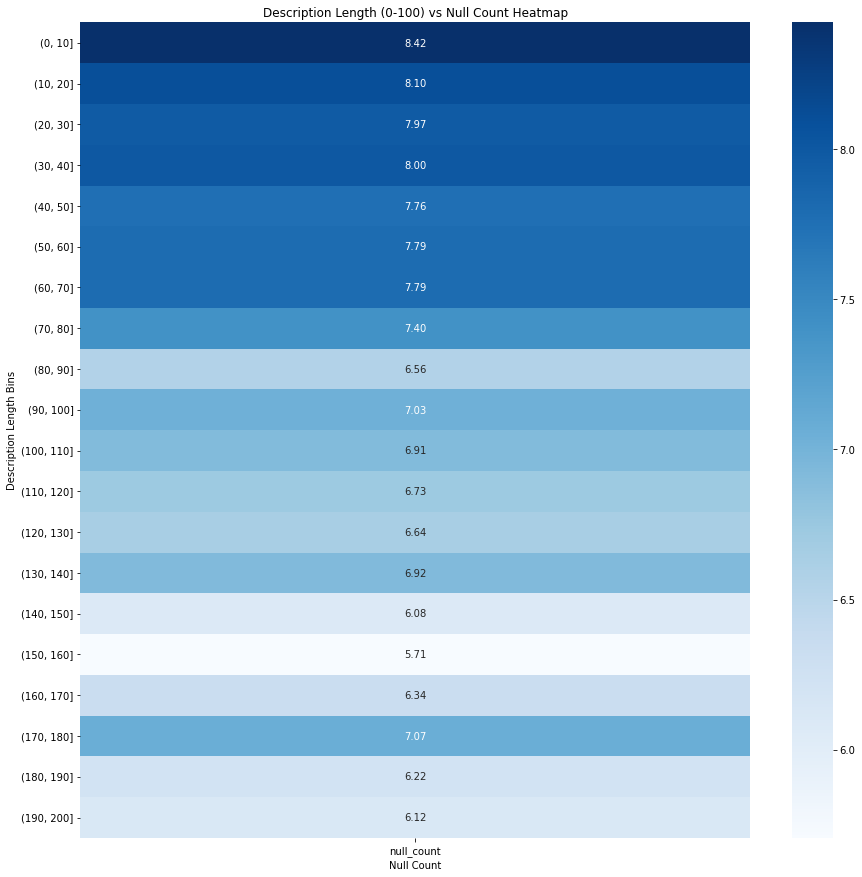

In [55]:
# description_length가 0에서 100 사이인 데이터만 필터링
df_filtered = df[(df['description_length'] >= 0) & (df['description_length'] <= 200)]

# Description Length를 10 단위로 구분
df_filtered['description_bin'] = pd.cut(df_filtered['description_length'], bins=range(0, 210, 10))

# 각 구간(description_bin)별로 null_count의 평균을 계산
heatmap_data = df_filtered.groupby('description_bin')['null_count'].mean().reset_index()

# 피벗 테이블 형태로 변환
heatmap_data_pivot = heatmap_data.pivot_table(index='description_bin', values='null_count')

# 히트맵 그리기
plt.figure(figsize=(15, 15))
sns.heatmap(heatmap_data_pivot, annot=True, cmap='Blues', fmt='.2f')

plt.title('Description Length (0-100) vs Null Count Heatmap')
plt.ylabel('Description Length Bins')
plt.xlabel('Null Count')

plt.show()